In [1]:
import argparse
import datetime
import logging
import os
import sys
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
# torch.set_default_tensor_type(torch.DoubleTensor)
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


# Data

In [3]:
K = 40
r = 0.05
sigma = 0.25
T = 1
S_range = [0, 130]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)

In [4]:
import utils

samples = {"pde": 5000, "bc":500, "fc":500}

bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, 
                       r, 
                       sigma, 
                       T, 
                       S_range[-1], 
                       S_range, 
                       t_range, 
                       gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)

In [5]:
print(n_st_train)

[[6.96469186e-01 7.03696995e+01]
 [2.86139335e-01 2.92731373e+01]
 [2.26851454e-01 1.08896395e+02]
 ...
 [4.31624265e-01 1.28068843e+02]
 [9.42709792e-01 2.86860758e+01]
 [4.39930699e-02 7.97286316e+01]]


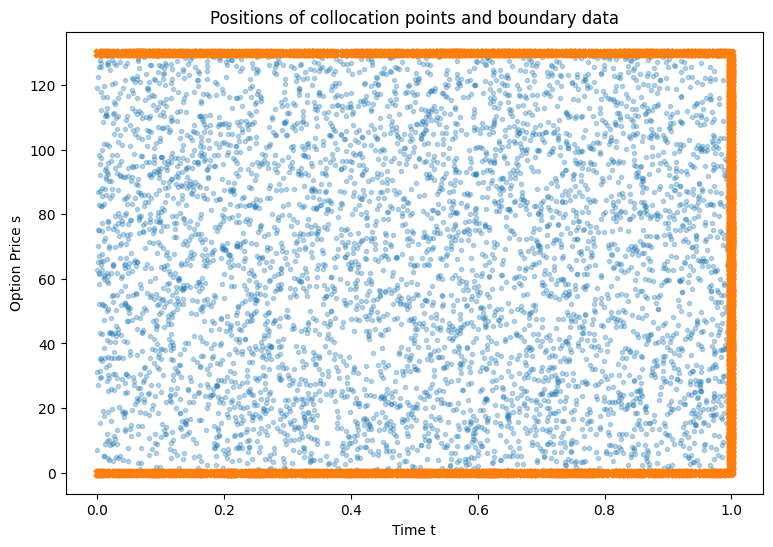

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter([sublist[0] for sublist in n_st_train], [sublist[1] for sublist in n_st_train], marker='.',alpha=0.3)
plt.scatter([sublist[0] for sublist in bc_st_train], [sublist[1] for sublist in bc_st_train], marker='X')
plt.xlabel('Time t')
plt.ylabel('Option Price s')

plt.title('Positions of collocation points and boundary data');

# Network

In [7]:
class AdaptiveLinear(nn.Linear):
    r"""Applies a linear transformation to the input data as follows
    :math:`y = naxA^T + b`.
    More details available in Jagtap, A. D. et al. Locally adaptive
    activation functions with slope recovery for deep and
    physics-informed neural networks, Proc. R. Soc. 2020.

    Parameters
    ----------
    in_features : int
        The size of each input sample
    out_features : int 
        The size of each output sample
    bias : bool, optional
        If set to ``False``, the layer will not learn an additive bias
    adaptive_rate : float, optional
        Scalable adaptive rate parameter for activation function that
        is added layer-wise for each neuron separately. It is treated
        as learnable parameter and will be optimized using a optimizer
        of choice 
        (self.A is the learnable parameter which is initialized by the 
        self.adaptive rate. To create a learnable parameter for each neuron, 
        it multiplies the self.adaptive rate to the number of input features.)
    adaptive_rate_scaler : float, optional
        Fixed, pre-defined, scaling factor for adaptive activation
        functions
    """
    def __init__(self, in_features, out_features, bias=True, adaptive_rate=None, adaptive_rate_scaler=None):
        super(AdaptiveLinear, self).__init__(in_features, out_features, bias)
        self.adaptive_rate = adaptive_rate
        self.adaptive_rate_scaler = adaptive_rate_scaler
        if self.adaptive_rate:
            self.A = nn.Parameter(self.adaptive_rate * torch.ones(self.in_features))
            if not self.adaptive_rate_scaler:
                self.adaptive_rate_scaler = 10.0
            
    def forward(self, input):
        if self.adaptive_rate:
            return nn.functional.linear(self.adaptive_rate_scaler * self.A * input, self.weight, self.bias)
        return nn.functional.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return (
            f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}, '
            f'adaptive_rate={self.adaptive_rate is not None}, adaptive_rate_scaler={self.adaptive_rate_scaler is not None}'
        )



class Net(nn.Module):
    r"""Neural approximator for the unknown function that is supposed
    to be solved.

    More details available in Raissi, M. et al. Physics-informed neural
    networks: A deep learning framework for solving forward and inverse
    problems involving nonlinear partial differential equations, J.
    Comput. Phys. 2019.

    Parameters
    ----------
    sizes : list
        Each element represents the number of neuron per layer
    activation : callable 
        Activation function
    dropout_rate : float, optional
        Dropout rate for regulrization during training process and
        uncertainty quantification by means of Monte Carlo dropout
        procedure while performing evaluation
    adaptive_rate : float, optional
        Scalable adaptive rate parameter for activation function that
        is added layer-wise for each neuron separately. It is treated
        as learnable parameter and will be optimized using a optimizer
        of choice
    adaptive_rate_scaler : float, optional
        Fixed, pre-defined, scaling factor for adaptive activation
        functions
    """
    def __init__(self, sizes, activation, dropout_rate=0.0, adaptive_rate=None, adaptive_rate_scaler=None):
        super(Net, self).__init__()
        self.regressor = nn.Sequential(
            *[Net.linear_block(in_features, out_features, activation, dropout_rate, adaptive_rate, adaptive_rate_scaler)
            for in_features, out_features in zip(sizes[:-1], sizes[1:-1])],     
            AdaptiveLinear(sizes[-2], sizes[-1]) # output layer is regular linear transformation
            )
        
    def forward(self, x):
        return self.regressor(x)

    @staticmethod
    def linear_block(in_features, out_features, activation, dropout_rate, adaptive_rate, adaptive_rate_scaler):
        activation_dispatcher = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU()],
            ['relu', nn.ReLU()],
            ['tanh', nn.Tanh()],
            ['sigmoid', nn.Sigmoid()],
            # ['swish', Swish()]
        ])
        return nn.Sequential(
            AdaptiveLinear(in_features, out_features, adaptive_rate=adaptive_rate, adaptive_rate_scaler=adaptive_rate_scaler),
            activation_dispatcher[activation],
            nn.Dropout(dropout_rate),
            )



In [8]:
IPINN = Net(
    sizes=[2, 50, 50, 50, 1], activation='relu', dropout_rate=0, adaptive_rate=0.1, adaptive_rate_scaler=5.0
    )
IPINN.cuda()

Net(
  (regressor): Sequential(
    (0): Sequential(
      (0): AdaptiveLinear(in_features=2, out_features=50, bias=True, adaptive_rate=True, adaptive_rate_scaler=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
    (1): Sequential(
      (0): AdaptiveLinear(in_features=50, out_features=50, bias=True, adaptive_rate=True, adaptive_rate_scaler=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
    (2): Sequential(
      (0): AdaptiveLinear(in_features=50, out_features=50, bias=True, adaptive_rate=True, adaptive_rate_scaler=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
    (3): AdaptiveLinear(in_features=50, out_features=1, bias=True, adaptive_rate=False, adaptive_rate_scaler=False)
  )
)

# Train

In [9]:
n_epochs = 30000
adaptive_rate = 0.1
lossFunction = nn.MSELoss()
lr = 0.00003
optimizer = optim.Adam(IPINN.parameters(), lr=lr)

- linspace: space the batch of data linearly, otherwise random, type=float
- domain: Boundaries of the solution domain, type=float
- batch_size: The number of adata points for optimization per epoch, type=float
- rhs: right-hand-side forcing function, type=float
- boundary_conditions: boundaru conditions on boundaries of the domain, type=float
- adaptive rate: add additional adaptive rate parameter to activation function, type=float

In [10]:
import time
import torch.autograd as tgrad

loss_hist = []
start_time = time.time()

# tqdm.tqdm(range(n_epochs), desc='[Training procedure]', ascii=True, total=n_epochs)

for _ in range(n_epochs):
        def closure():
            bc_st_train, bc_v_train, n_st_train, n_v_train = \
            utils.trainingData(K, 
                            r, 
                            sigma, 
                            T, 
                            S_range[-1], 
                            S_range, 
                            t_range, 
                            gs, 
                            samples['bc'], 
                            samples['fc'], 
                            samples['pde'], 
                            RNG_key=123)
            
            # save training data points to tensor and send to device
            n_st_train = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
            n_v_train = torch.from_numpy(n_v_train).float().to(device)
            
            bc_st_train = torch.from_numpy(bc_st_train).float().to(device)
            bc_v_train = torch.from_numpy(bc_v_train).float().to(device)   
            
            
            # pde residual loss
            y1_hat = IPINN(n_st_train)
            grads = tgrad.grad(y1_hat, n_st_train, grad_outputs=torch.ones(y1_hat.shape).cuda(), 
                       retain_graph=True, create_graph=True, only_inputs=True)[0]
            dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
            grads2nd = tgrad.grad(dVdS, n_st_train, grad_outputs=torch.ones(dVdS.shape).cuda(), 
                          create_graph=True, only_inputs=True, allow_unused=True)[0]
            S1 = n_st_train[:, 1].view(-1, 1)
            d2VdS2 = grads2nd[:, 1].view(-1, 1)
            pde_loss = lossFunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*y1_hat)
            
            
            # boudary condition loss
            y21_hat = IPINN(bc_st_train)
            bc_loss = lossFunction(bc_v_train, y21_hat)
            
            
            
            if adaptive_rate:
                local_recovery_terms = torch.tensor([torch.mean(IPINN.regressor[layer][0].A.data) for layer in range(len(IPINN.regressor) - 1)])
                slope_recovery_term = 1 / torch.mean(torch.exp(local_recovery_terms))
                loss = 1 *pde_loss + 1*bc_loss + slope_recovery_term
            else:
                loss = 1*pde_loss + 1*bc_loss
                
                
            
            optimizer.zero_grad()
            loss.backward()
            
            total_loss = pde_loss + bc_loss
            loss_hist.append(total_loss.item())
            
            if _ % 500 == 0:
                print(f'{_}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BC Loss: {bc_loss.item():.5f}, reg_loss: {slope_recovery_term.item(): 5f}, total loss: {total_loss.item():5f}, minimum loss: {min(loss_hist):.5f}')
            
            return loss
        optimizer.step(closure)
elapsed = timer() - start_time
end_time = time.time()
print('run time:', end_time - start_time)
logging.info(f'Training finished. Elapsed time: {elapsed} s\n')

0/30000 PDE Loss: 0.00002, BC Loss: 3386.53564, reg_loss:  0.904837, total loss: 3386.535645, minimum loss: 3386.53564
500/30000 PDE Loss: 0.00003, BC Loss: 2915.98975, reg_loss:  0.901148, total loss: 2915.989746, minimum loss: 2915.98975
1000/30000 PDE Loss: 0.00012, BC Loss: 1080.52954, reg_loss:  0.893023, total loss: 1080.529663, minimum loss: 1080.52966
1500/30000 PDE Loss: 0.00244, BC Loss: 79.08040, reg_loss:  0.883821, total loss: 79.082840, minimum loss: 79.08284
2000/30000 PDE Loss: 0.10881, BC Loss: 69.18098, reg_loss:  0.874025, total loss: 69.289787, minimum loss: 69.28979
2500/30000 PDE Loss: 0.82179, BC Loss: 59.14111, reg_loss:  0.867138, total loss: 59.962906, minimum loss: 59.96291
3000/30000 PDE Loss: 3.21392, BC Loss: 46.09874, reg_loss:  0.861932, total loss: 49.312660, minimum loss: 49.31266
3500/30000 PDE Loss: 5.79123, BC Loss: 34.20130, reg_loss:  0.860057, total loss: 39.992523, minimum loss: 39.99252
4000/30000 PDE Loss: 5.46434, BC Loss: 24.47442, reg_loss:

KeyboardInterrupt: 

Text(0.5, 1.0, 'IPINN')

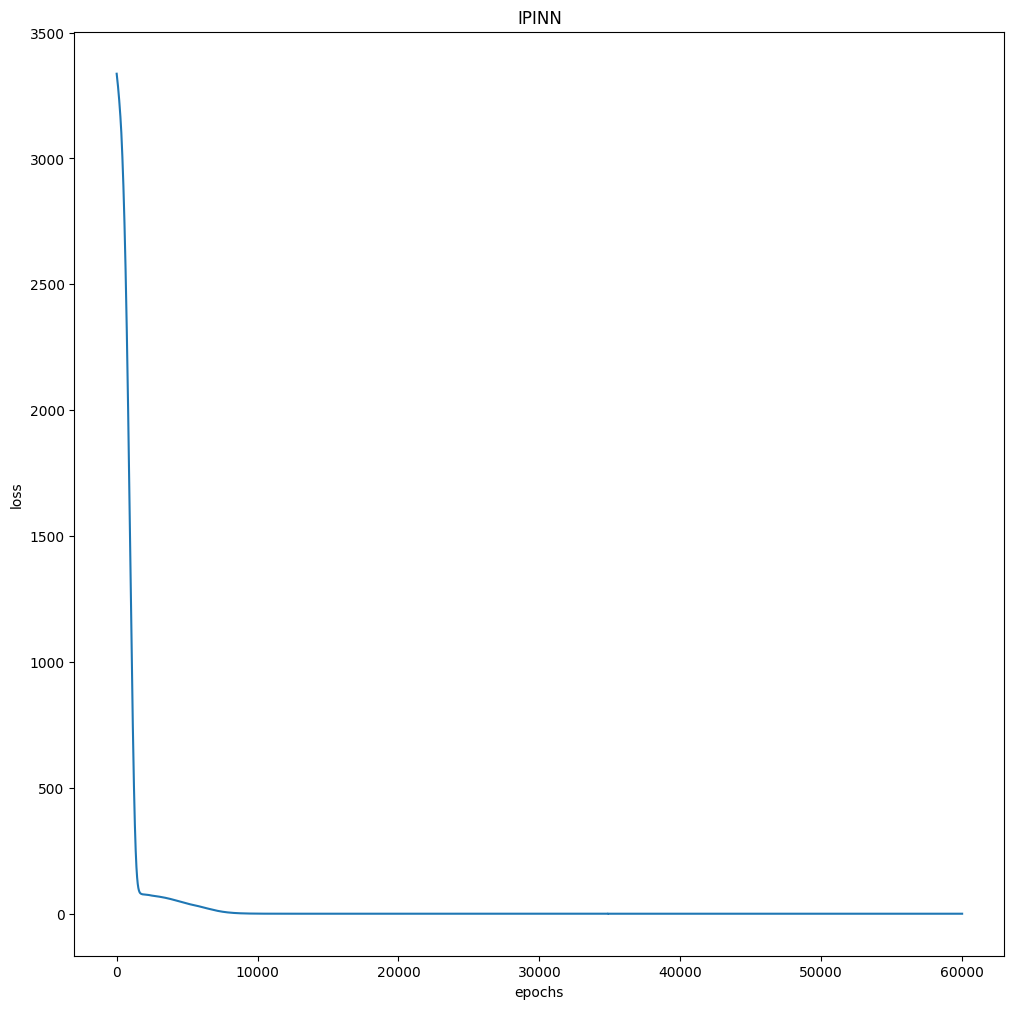

In [ ]:
fig = plt.figure(figsize=(12,12))
plt.plot(range(n_epochs), loss_hist)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('IPINN')